In [1]:
import os
import requests
import random
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, ConcatDataset, Subset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


# 💾 Download dataset and pre-trained model

In this section, we'll load a sample dataset (CIFAR-10), a pre-trained model (ResNet18) trained on CIFAR-10, plot some images and compute the accuracy of the model on the test set.

In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

We'll now download the weights of the model trained in CIFAR-10 and load them in a Pytorch model. This model has been trained using SGD with a learning rate of 0.1, momentum of 0.9 and weight decay of 5e-4. It was also trained using data augmentation. In particular, the transforms used to the data were:

```python
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
```


In [4]:
# load pre-trained weights
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

We'll now compute the model's accuracy on the train and test set.


In [5]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    net.eval()
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Retain set accuracy: {100.0 * accuracy(model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(model, forget_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 99.3%
Test set accuracy: 88.3%


# 🎯 Unlearning Algorithm

In [6]:
def create_new_dataloader_from_existing(original_dataloader, new_transforms, resize_factor=3):
    # Extract the original dataset
    original_dataset = original_dataloader.dataset
    
    # Create a deep copy of the original dataset
    new_dataset = copy.deepcopy(original_dataset)
    
    # Apply new transformations
    new_dataset.transform = new_transforms
    
    # Extract DataLoader settings from the original DataLoader
    batch_size = original_dataloader.batch_size
    shuffle = isinstance(original_dataloader.sampler, torch.utils.data.RandomSampler)
    num_workers = original_dataloader.num_workers
    pin_memory = original_dataloader.pin_memory
    drop_last = original_dataloader.drop_last
    timeout = original_dataloader.timeout
    worker_init_fn = original_dataloader.worker_init_fn

    # Create a new DataLoader
    new_dataloader = DataLoader(
        new_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn
    )
    
    # If you want to make the new dataset 'resize_factor' times the size of the original dataset
    if resize_factor > 1:
        new_dataset = ConcatDataset([new_dataset] * resize_factor)
        new_dataloader = DataLoader(
            new_dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn
        )
        
    return new_dataloader

In [7]:
# New transformations
new_transforms = transforms.Compose([
    transforms.RandomCrop(31, padding=4),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
    transforms.ToTensor(),
])

In [8]:
new_forget_loader = create_new_dataloader_from_existing(forget_loader, new_transforms, resize_factor=3)

In [9]:
# images, labels = next(iter(new_forget_loader))

# fig, ax = plt.subplots(figsize=(12, 6))
# plt.title("Sample images from CIFAR10 dataset")
# ax.set_xticks([])
# ax.set_yticks([])
# ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
# plt.show()

In [10]:
# Function to update learning rate
def adjust_learning_rate(optimizer, current_batch, total_batches, initial_lr):
    """Sets the learning rate for warmup over total_batches"""
    lr = initial_lr * (current_batch / total_batches)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [23]:
def unlearning(net, retain, forget, validation, num_layers_to_finetune=1):

    # Freeze the first N-X layers
    ct = 0
    for name, param in net.named_parameters():
        ct += 1
        if ct < num_layers_to_finetune:
            param.requires_grad = False
        else:
            param.requires_grad = True

    epochs = 1
    total_samples = len(retain.dataset)
    batch_size = retain.batch_size
    batches_per_epoch  = math.ceil(total_samples / batch_size)
    total_batches = epochs * batches_per_epoch
    initial_lr = 0.01
    warmup_batches = math.ceil(0.4*total_batches)

    current_batch = 0

    early_stop_steps = 1000  # Number of steps to consider for early stopping
    early_stop_threshold = 0.03  # 5% validation performance decrease

    criterion = nn.CrossEntropyLoss()
    optimizer_retain = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    optimizer_forget = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)
    scheduler_retain = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_retain, T_max=epochs)
    scheduler_forget = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_forget, T_max=epochs)

    # Record the original performance on the validation set
    original_val_accuracy = accuracy(net, validation)
    print(f'Original val acc: {original_val_accuracy}')
    
    net.train()
    steps_without_improvement = 0
    step_count = 0
    downsample_pct = 0

    # combined_loader = combine_loaders_randomly(retain, forget, net)

    for _ in range(epochs):

        # Initialize iterators at the beginning of each epoch
        iter_retain = iter(retain)
        iter_forget = iter(forget)

        # Initialize weights for random selection
        weights = torch.tensor([95, 5], dtype=torch.float32)

        # Initialize flag for depleted iterator
        one_depleted = False

        while not one_depleted:
        # for _ in range(150):
        # Randomly choose a loader based on weights
            chosen_loader_idx = torch.multinomial(weights, 1).item()

            if chosen_loader_idx == 0:  # corresponds to retain_loader

                if torch.rand(1).item() < downsample_pct:
                    continue  # Skip to the next iteration

                try:
                    batch = next(iter_retain)
                    optimizer = optimizer_retain
                except StopIteration:
                    one_depleted = True
                    continue  # Skip to the next iteration
                    
            else:  # corresponds to forget_loader
                try:
                    batch = next(iter_forget)
                    optimizer = optimizer_forget
                except StopIteration:
                    one_depleted = True
                    continue  # Skip to the next iteration
            # print(batch)
            # for inputs, targets in batch:
            inputs, targets = batch

            if chosen_loader_idx == 1:
                # Compute new targets
                with torch.no_grad():
                    net.eval()
                    preds = net(inputs.to(DEVICE))
                    _, targets = torch.topk(preds, 2, dim=1)
                    targets = targets[:, -1]
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                
            current_batch += 1

            # Warm-up for the first 'warmup_batches' batches
            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            net.train()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            step_count += 1

            # Evaluate on validation set
            # current_val_accuracy = accuracy(net, validation)
            # print(f"Validation acc {current_val_accuracy:.4f}")

            # Check for performance decrease
            # if current_val_accuracy < (1 - early_stop_threshold) * original_val_accuracy:
            #     steps_without_improvement += 1
            #     if steps_without_improvement >= early_stop_steps:
            #         print(f"Early stopping triggered at step {step_count}.")
            #         net.eval()
            #         return net
            # else:
            #     steps_without_improvement = 0

        scheduler_retain.step()
        scheduler_forget.step()

    net.eval()
    return net

In [24]:
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
ft_model = unlearning(ft_model, retain_loader, forget_loader, val_loader)

Original val acc: 0.8894


## Pre-trained model performance
- Retain set accuracy: 99.5%
- Forget set accuracy: 99.3%
- Test set accuracy: 88.3%

In [25]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(ft_model, forget_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(ft_model, new_forget_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")

Retain set accuracy: 97.0%
Forget set accuracy: 92.7%
Forget set accuracy: 92.7%
Test set accuracy: 85.9%


# 🏅 Evaluation

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). We provide this simple MIA for convenience so that participants can quickly obtain a metric for their unlearning algorithm, but submissions will be scored using a different method.

This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained model on the train and test set

In [30]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

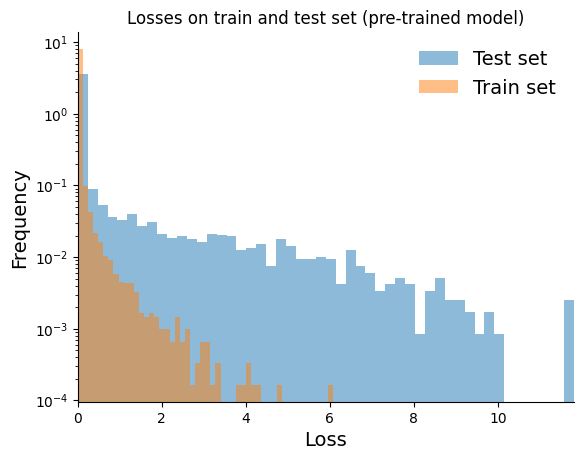

In [31]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

As per the above plot, the distributions of losses are quite different between the train and test sets, as expected. In what follows, we will define an MIA that leverages the fact that examples that were trained on have smaller losses compared to examples that weren't. Using this fact, the simple MIA defined below will aim to infer whether the forget set was in fact part of the training set.

This MIA is defined below. It takes as input the per-sample losses of the unlearned model on forget and test examples, and a membership label (0 or 1) indicating which of those two groups each sample comes from. It then returns the cross-validation accuracy of a linear model trained to distinguish between the two classes.

Intuitively, an unlearning algorithm is successful with respect to this simple metric if the attacker isn't able to distinguish the forget set from the test set any better than it would for the ideal unlearning algorithm (retraining from scratch without the retain set); see the last section of this notebook for additional discussion and for computing that reference point.

In [32]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [33]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.579 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [34]:
ft_forget_losses = compute_losses(ft_model, forget_loader)
ft_test_losses = compute_losses(ft_model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [35]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.616 on forgotten vs unseen images


From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001D71CA92290>
Traceback (most recent call last):
  File "c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001D71CA92290>
Traceback (most recent call last):
  File "c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\to

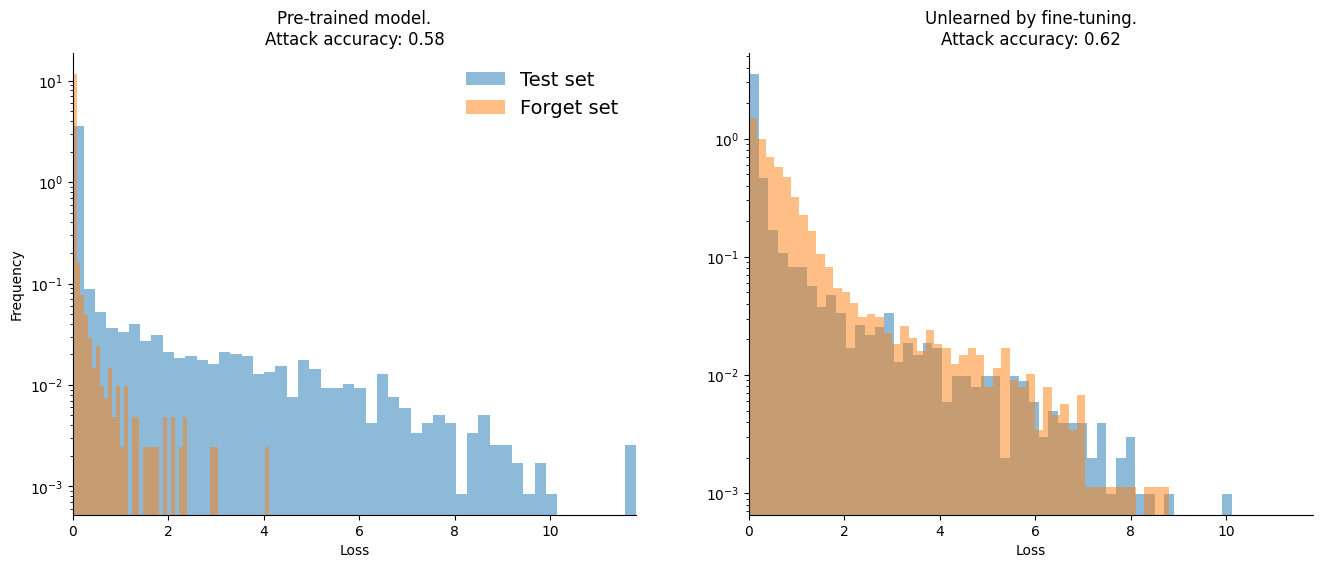

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Comparison with a re-trained model

One might ask, how good are the scores above? What is the best score? Since our goal is to approximate the model that has been trained only on the retain set, we'll consider that the gold standard is the score achieved by this model. Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

We'll now compute this score. We'll first download the weights for a model trained exclusively on the retain set and then compute the accuracy of the simple MIA.

In [38]:
# download weights of a model trained exclusively on the retain set
local_path = "../example notebooks/weights/retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/retrain_weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 88.2%


As expected, the model trained exclusively on the retain set has a higher accuracy on the retain set than on the forget set (whose accuracy is similar than on the test set)

In [ ]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [ ]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.497 on forgotten vs unseen images


As we expect, the accuracy of the MIA attack is roughly 0.5. Finally, as we've done before, let's compare the histograms of this ideal algorithm (re-trained model) vs the model obtain from

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()